In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ipywidgets import interact, SelectionSlider, IntSlider

In [2]:
%time df_c_before = pd.read_csv('c_before.csv')
%time df_c_after = pd.read_csv('c_after.csv')

CPU times: user 4.24 s, sys: 294 ms, total: 4.53 s
Wall time: 4.55 s
CPU times: user 4.24 s, sys: 298 ms, total: 4.54 s
Wall time: 4.62 s


In [3]:
%time df_jval = pd.read_csv('jval.csv')
%time df_phy = pd.read_csv('phy.csv')

CPU times: user 1.98 s, sys: 130 ms, total: 2.11 s
Wall time: 2.15 s
CPU times: user 64.4 ms, sys: 7.48 ms, total: 71.9 ms
Wall time: 72.1 ms


In [4]:
df_c_before.shape, df_jval.shape

((66240, 218), (66240, 122))

In [5]:
df_in = pd.concat([df_c_before, df_phy, df_jval], axis=1)
df_in.head()

,CH2I2,CH2ICl,CH2IBr,AERI,INDIOL,ISALA,ISALC,ISN1OA,ISN1OG,LVOCOA,...,121/IONO2/IONO2,122/I2O2/I2O2,123/CH3I/CH3I,124/CH2I2/CH2I2,125/CH2ICl/CH2ICl,126/CH2IBr/CH2IBr,127/I2O4/I2O2,128/I2O3/I2O3,129/IBr/IBr,130/ICl/ICl
0,5721.954735,1.661646e+06,144616.006849,253087.29189,8.821088e+06,396480.350095,9878.959109,60996.225341,1.380585,246923.607262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5721.954735,1.661646e+06,144616.006849,253087.29189,8.821088e+06,396480.350095,9878.959109,60996.225341,1.380585,246923.607262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5721.954735,1.661646e+06,144616.006849,253087.29189,8.821088e+06,396480.350095,9878.959109,60996.225341,1.380585,246923.607262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5721.954735,1.661646e+06,144616.006849,253087.29189,8.821088e+06,396480.350095,9878.959109,60996.225341,1.380585,246923.607262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5721.954735,1.661646e+06,144616.006849,253087.29189,8.821088e+06,396480.350095,9878.959109,60996.225341,1.380585,246923.607262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Fitting

In [6]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

In [7]:
X_all = df_in.values
X_all.shape

(66240, 344)

In [8]:
Y_all = df_c_after['NO'].values

In [9]:
Y_all.shape

(66240,)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)

# Single model

In [11]:
model_tree = DecisionTreeRegressor()
model_tree

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [12]:
model_tree = DecisionTreeRegressor(max_leaf_nodes=2000)

In [13]:
%time model_tree.fit(X_train, Y_train)

CPU times: user 17.9 s, sys: 175 ms, total: 18.1 s
Wall time: 18.3 s


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=2000, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [14]:
Y_pred_train = model_tree.predict(X_train)
Y_pred_test = model_tree.predict(X_test)

In [15]:
r2_score(Y_pred_train, Y_train), r2_score(Y_pred_test, Y_test)

(0.9998803764587633, 0.9615458360918296)

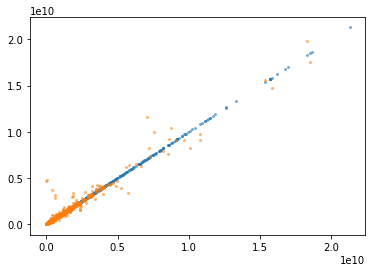

In [16]:
plt.scatter(Y_pred_train, Y_train, alpha=0.5, s=4)
plt.scatter(Y_pred_test, Y_test, alpha=0.5, s=4)

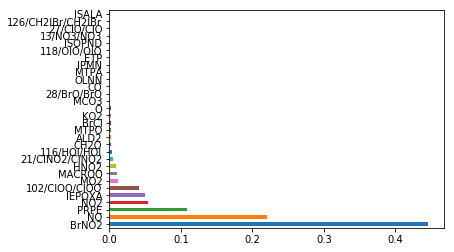

In [17]:
# feature importance diagnostics
feat_importances = pd.Series(model_tree.feature_importances_, index=df_in.columns)
feat_importances.nlargest(30).plot(kind='barh')

# Ensemble model

In [18]:
from sklearn.ensemble import RandomForestRegressor

/Users/zhuangjw/Research/Computing/miniconda3/envs/sci/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [19]:
model_rf = RandomForestRegressor(max_leaf_nodes=2000, n_estimators=10, n_jobs=-1, verbose=2)
model_rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=2000,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=2, warm_start=False)

In [20]:
%time model_rf.fit(X_train, Y_train)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10building tree 4 of 10

building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
CPU times: user 2min 17s, sys: 398 ms, total: 2min 17s
Wall time: 42.2 s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   42.2s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=2000,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=2, warm_start=False)

In [21]:
Y_pred_train_em = model_rf.predict(X_train)
Y_pred_test_em = model_rf.predict(X_test)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


In [22]:
r2_score(Y_pred_train_em, Y_train), r2_score(Y_pred_test_em, Y_test)

(0.9933956957391142, 0.9635271251939794)

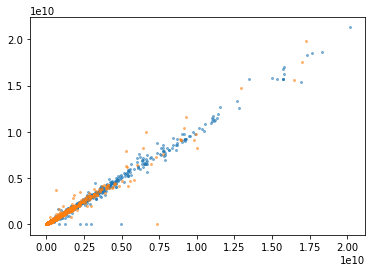

In [23]:
plt.scatter(Y_pred_train_em, Y_train, alpha=0.5, s=4)
plt.scatter(Y_pred_test_em, Y_test, alpha=0.5, s=4)

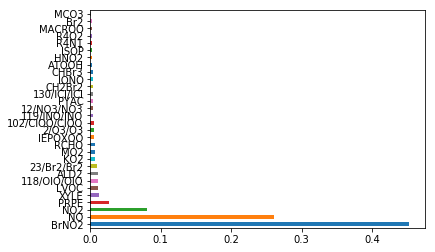

In [24]:
# feature importance diagnostics
feat_importances = pd.Series(model_rf.feature_importances_, index=df_in.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [25]:
ensemble_pred_train = []
ensemble_pred_test = []

for tree in model_rf.estimators_:
    ensemble_pred_train.append(tree.predict(X_train))
    ensemble_pred_test.append(tree.predict(X_test))
    
ensemble_pred_train = np.array(ensemble_pred_train)
ensemble_pred_test = np.array(ensemble_pred_test)

In [26]:
ensemble_pred_test.shape

(10, 13248)

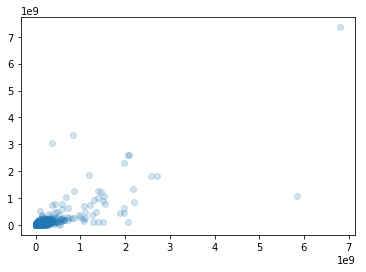

In [27]:
plt.scatter(ensemble_pred_test.std(axis=0), np.abs(Y_pred_test_em-Y_test), alpha=0.2)

<ErrorbarContainer object of 3 artists>

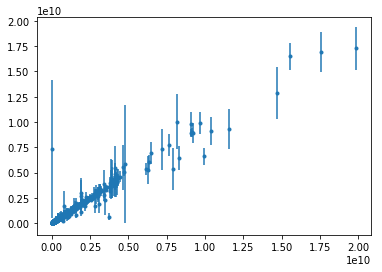

In [28]:
plt.errorbar(Y_test, Y_pred_test_em, yerr=ensemble_pred_test.std(axis=0), fmt='.')